# Importing Libraries

In [60]:
import requests
import json
import os
import sys
import time
import re
import pytumblr
import random
import pandas as pd
from gensim.corpora import Dictionary
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import mmh3
from bitarray import bitarray
from wordcloud import WordCloud
import emoji
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# API Configurations

In [2]:
client = pytumblr.TumblrRestClient(
  '8VJ7B3ncYSK3NKttmvGvjL9JECJSTiO5NHqg9naYKY4OnN4Wmo',
  'jQctywNQJFrPeptUCyzNZzvThlHSqUGAA1e7SDIYbnJ8pOqJAU',
  'nzN0PNfvcV9AP41hL2jeTfkDpHbZID5c6hVEeggXmsQTGP42K1',
  '80bRrYHqspONyBZcPEJi2xYiuN2GUMsR2peE0Yxk5dfb50rLHf'
)

In [3]:
print(type(client))

<class 'pytumblr.TumblrRestClient'>


# Topics for Identification

In [4]:
# Programming (Label 0)
keywords_programming = ['Coding', 'Testing', 'python', 'tech', 'software', 'development', 'web development', 'web design', 'web dev', 'c', 'cpp', 'c++', 'pointers', 'java', 'javascript', 'computer science', 'computer engineering', 'AI', 'dev', 'machine learning', 'development', 'blockchain', 'data science', 'software engineering', 'algorithms', 'tech community', 'programming', 'coding', 'software architecture', 'computer programming']

In [5]:
# Cooking (Label 1)
keywords_cooking = ['cooking', 'baking', 'food', 'recipes', 'recipe', 'chef', 'kitchen', 'cook', 'bake', 'foodie', 'foodporn', 'foodgasm', 'foodblog', 'foodblogger', 'foodblogging', 'foodbloggers', 'pasta', 'cranberry', 'chocolate', 'pancake', 'health', 'breakfast', 'snack', 'dinner', 'lunch' ,'steak', 'meat', 'chicken', 'veggie', 'burger']

In [6]:
# Sports (Label 2)
keywords_sports = ['sports', 'football', 'soccer', 'basketball', 'baseball', 'hockey', 'tennis', 'golf', 'rugby', 'cricket', 'volleyball', 'swimming', 'running', 'cycling', 'athletics', 'track and field', 'track', 'field', 'olympics', 'athletes', 'NFL', 'sportswomen', 'sportsman', 'sportswoman', 'NBA', 'EPL', 'MLB', 'sport', 'exercise', 'yoga']

In [7]:
# Random blogs (Label 3)
keywords_other = ['aesthetic', 'love', 'photography', 'art', 'nature', 'inspiration', 'vintage', 'creativity', 'beauty', 'grunge', 'fashion', 'travel', 'quotes', 'poetry', 'music', 'film', 'cinematography', 'graphic design', 'anime', 'kawaii', 'pastel', 'hipster', 'tattoos', 'boho', 'witchy', 'plants', 'street style', 'minimalism', 'urban exploration', 'movies']

In [8]:
print('Number of Keywords for Programming: ', len(keywords_programming))
print('Number of Keywords for Cooking: ', len(keywords_cooking))
print('Number of Keywords for Sports: ', len(keywords_sports))
print('Number of Keywords for Other: ', len(keywords_other))

Number of Keywords for Programming:  30
Number of Keywords for Cooking:  30
Number of Keywords for Sports:  30
Number of Keywords for Other:  30


# Bloom Filter Implementation

In [9]:
class BloomFilter:
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def add(self, item):
        for i in range(self.hash_count):
            index = mmh3.hash(item, i) % self.size
            self.bit_array[index] = 1

    def __contains__(self, item):
        for i in range(self.hash_count):
            index = mmh3.hash(item, i) % self.size
            if self.bit_array[index] == 0:
                return False
        return True

In [10]:
# Testing the Filter
bloom_filter_size = 1000  
hash_functions_count = 8   
bloom_filter_test = BloomFilter(bloom_filter_size, hash_functions_count)

In [11]:
for keyword in keywords_programming:
    bloom_filter_test.add(keyword)

In [12]:
test_keywords = ['python', 'machine learning', 'football', 'greece', 'java', 'art', 'banking', 'AI']
for keyword in test_keywords:
    if keyword in bloom_filter_test:
        print(f"'{keyword}' may be in the set (false positive possible)")
    else:
        print(f"'{keyword}' is definitely not in the set")

'python' may be in the set (false positive possible)
'machine learning' may be in the set (false positive possible)
'football' is definitely not in the set
'greece' is definitely not in the set
'java' may be in the set (false positive possible)
'art' is definitely not in the set
'banking' is definitely not in the set
'AI' may be in the set (false positive possible)


# Preparing a Dataset using Tumblr Posts for Topic Identification

In [13]:
def fetch_posts_by_tags_and_store(tags, num_posts=10, label = 1):
    try:
        posts_data = []
            
        for tag in tags:
            posts = client.tagged(tag, limit=num_posts)
            
            print("Fetched", len(posts), "posts for tags:", tag)
            
            for post in posts:
                post_data = {
                    'Post Timestamp': post['timestamp'],
                    'Post ID': post['id'],
                    'Blog Name': post['blog_name'],
                    'Post Type': post['type'],
                    'Tags': post['tags'],
                    'Post Summary': post.get('summary', ''),
                    'Label': label  
                }
                posts_data.append(post_data)

        df = pd.DataFrame(posts_data)
        
        return df

    except Exception as e:
        print("Error:", e)

In [32]:
df_programming = fetch_posts_by_tags_and_store(keywords_programming, num_posts=20, label=0)

Fetched 20 posts for tags: Coding
Fetched 20 posts for tags: Testing
Fetched 20 posts for tags: python
Fetched 20 posts for tags: tech
Fetched 20 posts for tags: software
Fetched 20 posts for tags: development
Fetched 20 posts for tags: web development
Fetched 20 posts for tags: web design
Fetched 20 posts for tags: web dev
Fetched 20 posts for tags: c
Fetched 15 posts for tags: cpp
Fetched 20 posts for tags: c++
Fetched 20 posts for tags: pointers
Fetched 20 posts for tags: java
Fetched 20 posts for tags: javascript
Fetched 20 posts for tags: computer science
Fetched 20 posts for tags: computer engineering
Fetched 20 posts for tags: AI
Fetched 20 posts for tags: dev
Fetched 20 posts for tags: machine learning
Fetched 20 posts for tags: development
Fetched 20 posts for tags: blockchain
Fetched 20 posts for tags: data science
Fetched 20 posts for tags: software engineering
Fetched 20 posts for tags: algorithms
Fetched 20 posts for tags: tech community
Fetched 20 posts for tags: programm

In [33]:
df_cooking = fetch_posts_by_tags_and_store(keywords_cooking, num_posts=20, label=1)

Fetched 20 posts for tags: cooking
Fetched 20 posts for tags: baking
Fetched 20 posts for tags: food
Fetched 20 posts for tags: recipes
Fetched 20 posts for tags: recipe
Fetched 20 posts for tags: chef
Fetched 20 posts for tags: kitchen
Fetched 20 posts for tags: cook
Fetched 20 posts for tags: bake
Fetched 20 posts for tags: foodie
Fetched 20 posts for tags: foodporn
Fetched 20 posts for tags: foodgasm
Fetched 20 posts for tags: foodblog
Fetched 20 posts for tags: foodblogger
Fetched 20 posts for tags: foodblogging
Fetched 11 posts for tags: foodbloggers
Fetched 20 posts for tags: pasta
Fetched 20 posts for tags: cranberry
Fetched 20 posts for tags: chocolate
Fetched 20 posts for tags: pancake
Fetched 20 posts for tags: health
Fetched 20 posts for tags: breakfast
Fetched 20 posts for tags: snack
Fetched 20 posts for tags: dinner
Fetched 20 posts for tags: lunch
Fetched 20 posts for tags: steak
Fetched 20 posts for tags: meat
Fetched 20 posts for tags: chicken
Fetched 20 posts for tags

In [34]:
df_sports = fetch_posts_by_tags_and_store(keywords_sports, num_posts=20, label=2)

Fetched 20 posts for tags: sports
Fetched 20 posts for tags: football
Fetched 20 posts for tags: soccer
Fetched 20 posts for tags: basketball
Fetched 20 posts for tags: baseball
Fetched 20 posts for tags: hockey
Fetched 20 posts for tags: tennis
Fetched 20 posts for tags: golf
Fetched 20 posts for tags: rugby
Fetched 20 posts for tags: cricket
Fetched 20 posts for tags: volleyball
Fetched 20 posts for tags: swimming
Fetched 20 posts for tags: running
Fetched 20 posts for tags: cycling
Fetched 20 posts for tags: athletics
Fetched 20 posts for tags: track and field
Fetched 20 posts for tags: track
Fetched 20 posts for tags: field
Fetched 20 posts for tags: olympics
Fetched 20 posts for tags: athletes
Fetched 20 posts for tags: NFL
Fetched 20 posts for tags: sportswomen
Fetched 20 posts for tags: sportsman
Fetched 10 posts for tags: sportswoman
Fetched 20 posts for tags: NBA
Fetched 20 posts for tags: EPL
Fetched 20 posts for tags: MLB
Fetched 20 posts for tags: sport
Fetched 20 posts for

In [37]:
df_other = fetch_posts_by_tags_and_store(keywords_other, num_posts=20, label=3)

Fetched 20 posts for tags: aesthetic
Fetched 20 posts for tags: love
Fetched 20 posts for tags: photography
Fetched 20 posts for tags: art
Fetched 20 posts for tags: nature
Fetched 20 posts for tags: inspiration
Fetched 20 posts for tags: vintage
Fetched 20 posts for tags: creativity
Fetched 20 posts for tags: beauty
Fetched 20 posts for tags: grunge
Fetched 20 posts for tags: fashion
Fetched 20 posts for tags: travel
Fetched 20 posts for tags: quotes
Fetched 20 posts for tags: poetry
Fetched 20 posts for tags: music
Fetched 20 posts for tags: film
Fetched 20 posts for tags: cinematography
Fetched 20 posts for tags: graphic design
Fetched 20 posts for tags: anime
Fetched 20 posts for tags: kawaii
Fetched 20 posts for tags: pastel
Fetched 20 posts for tags: hipster
Fetched 20 posts for tags: tattoos
Fetched 20 posts for tags: boho
Fetched 20 posts for tags: witchy
Fetched 20 posts for tags: plants
Fetched 20 posts for tags: street style
Fetched 20 posts for tags: minimalism
Fetched 20 p

In [38]:
df = pd.concat([df_programming, df_cooking, df_sports, df_other])

In [39]:
df.head()

Post Timestamp             Post ID           Blog Name Post Type  \
0      1709641230  744112763121598464            izicodes      text   
1      1709641170  744112699872591872       frogdisguised      text   
2      1709640010  744111483623997440          donutwares      text   
3      1709636600  744107907486990336               edoxi      text   
4      1709636557  744107863250714624  turtle-programming      text   

                                                Tags  \
0  [5in5weeks, study challenge, programming, codi...   
1  [coding, html, screaming crying throwing up, i...   
2  [coding, affordable watches, christian, telepa...   
3  [edoxitraininginstitute, coding, coding memes,...   
4  [coding, learning, programmieren, programming,...   

                                        Post Summary  Label  
0  Tuesday 5th March 2024 - [ Week 1 Day 3 ]\nTod...      0  
1                                                         0  
2                              Switched some straps…      0  
3  You haven't known real happiness until you hav...      0  
4              Python Turtle Programming Academy ...      0

In [40]:
print(df.shape)

(2376, 7)


In [42]:
print(df['Label'].value_counts())

3    600
0    595
1    591
2    590
Name: Label, dtype: int64


In [41]:
df.to_csv('tumblr_posts_dataset.csv', index=False)

# Preprocessing Dataset

In [14]:
df_final = pd.read_csv('tumblr_posts_dataset.csv')

In [15]:
df_final.head()

Post Timestamp             Post ID           Blog Name Post Type  \
0      1709641230  744112763121598464            izicodes      text   
1      1709641170  744112699872591872       frogdisguised      text   
2      1709640010  744111483623997440          donutwares      text   
3      1709636600  744107907486990336               edoxi      text   
4      1709636557  744107863250714624  turtle-programming      text   

                                                Tags  \
0  ['5in5weeks', 'study challenge', 'programming'...   
1  ['coding', 'html', 'screaming crying throwing ...   
2  ['coding', 'affordable watches', 'christian', ...   
3  ['edoxitraininginstitute', 'coding', 'coding m...   
4  ['coding', 'learning', 'programmieren', 'progr...   

                                        Post Summary  Label  
0  Tuesday 5th March 2024 - [ Week 1 Day 3 ]\nTod...      0  
1                                                NaN      0  
2                              Switched some straps…      0  
3  You haven't known real happiness until you hav...      0  
4              Python Turtle Programming Academy ...      0

In [16]:
for index, row in df_final.iterrows():
    # Convert 'Post Summary' value to string
    post_summary = str(row['Post Summary'])
    # Split the 'Tags' string into a list of tags
    tags_list = row['Tags'][1:-1].split(', ')
    # Concatenate 'Post Summary' and 'Tags' columns with a space in between
    concatenated_text = post_summary + ' ' + ' '.join(tags_list)
    # Update the 'Post Summary' column with the concatenated text
    df_final.at[index, 'Post Summary'] = concatenated_text

In [33]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [34]:
def data_preprocessing(df):

    for index, row in df.iterrows():
        text_value = row['Post Summary']

        #convert the text_value to str
        text_value = str(text_value)

        # lowercasing
        text_value = text_value.lower()

        # Remove URLs
        text_value = remove_urls(text_value)

        # Remove punctuation
        text_value = re.sub(r'[^\w\s]', '', text_value)

        # remove stopwords
        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

        # lemmatization
        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])
        
        # store the cleaned text
        df.at[index, 'Post Summary'] = text_value

    return df

In [19]:
df_final = data_preprocessing(df_final)

In [20]:
df_final.head()

Post Timestamp             Post ID           Blog Name Post Type  \
0      1709641230  744112763121598464            izicodes      text   
1      1709641170  744112699872591872       frogdisguised      text   
2      1709640010  744111483623997440          donutwares      text   
3      1709636600  744107907486990336               edoxi      text   
4      1709636557  744107863250714624  turtle-programming      text   

                                                Tags  \
0  ['5in5weeks', 'study challenge', 'programming'...   
1  ['coding', 'html', 'screaming crying throwing ...   
2  ['coding', 'affordable watches', 'christian', ...   
3  ['edoxitraininginstitute', 'coding', 'coding m...   
4  ['coding', 'learning', 'programmieren', 'progr...   

                                        Post Summary  Label  
0  tuesday 5th march 2024 week 1 day 3 today stud...      0  
1  nan coding html screaming cry throwing dont en...      0  
2  switched strap coding affordable watch christi...      0  
3  havent known real happiness experienced share ...      0  
4  python turtle programming academy coding learn...      0

In [81]:
df_final.to_csv('tumblr_posts_dataset_cleaned.csv', index=False)

# Machine Learning Model for Topic Identification

In [13]:
df_train = pd.read_csv('tumblr_posts_dataset_cleaned.csv')

# drop the 'Post Timestamp', 'Post ID', 'Blog Name', 'Post Type', 'Tags' columns
df_train = df_train.drop(['Post Timestamp', 'Post ID', 'Blog Name', 'Post Type', 'Tags'], axis=1)

df_train.head()

Post Summary  Label
0  tuesday 5th march 2024 week 1 day 3 today stud...      0
1  nan coding html screaming cry throwing dont en...      0
2  switched strap coding affordable watch christi...      0
3  havent known real happiness experienced share ...      0
4  python turtle programming academy coding learn...      0

In [14]:
import joblib

def linear_SVM(df):
    # Drop rows with missing values
    df.dropna(subset=['Post Summary'], inplace=True)

    # Defining the pipeline
    sgd = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                   ])
    
    X_train, X_test, y_train, y_test = train_test_split(df['Post Summary'], df['Label'], test_size=0.2, random_state=42)

    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    joblib.dump(sgd, 'linear_svm_model.pkl')

    return sgd, accuracy

def predict_label(sentence, model):
    loaded_model = joblib.load(model)
    label = loaded_model.predict([sentence])

    if label == 0:
        return 'Programming'

    elif label == 1:
        return 'Cooking'

    elif label == 2:
        return 'Sports'

    elif label == 3:
        return 'Other'

In [15]:
model, accuracy_score = linear_SVM(df_train)

In [16]:
print("Accuracy:", accuracy_score)

Accuracy: 0.9514767932489452


In [17]:
print(predict_label("I love to cook and bake", 'linear_svm_model.pkl'))

Cooking


In [18]:
print(predict_label("Can anyone help me with this code?", 'linear_svm_model.pkl'))

Programming


In [19]:
print(predict_label("Messi scores a goal!", 'linear_svm_model.pkl'))

Sports


In [20]:
print(predict_label("Beautiful landscape", 'linear_svm_model.pkl'))

Other


# Live Data Stream

In [21]:
additional_programming_tags = ['coding', 'debugging', 'frameworks', 'c++', 'libraries', 'security', 'pytorch', 'documentation']

In [22]:
additional_cooking_tags = ['grilling','desserts','sauce','spices','baking','barbecue','seafood','salad']

In [23]:
additional_sports_tags = ['training','fitness','competition','athletics','tournament','match','athlete','fans']

In [24]:
additional_other_tags = ['aesthetic','romance','landscape','painting','outdoors','motivation','retro','imagination','glamour','urban','expression','adventure','wisdom','melody','cinema','design','manga','cute','botanical','streetart']

In [25]:
all_keywords = additional_programming_tags + additional_cooking_tags + additional_sports_tags + additional_other_tags

In [26]:
random.shuffle(all_keywords)

In [27]:
def preprocess(tags, summary):
    if summary is None:
        summary = ''

    summary = str(summary)
    tags_list = tags
    concatenated_text = summary + ' ' + ' '.join(tags_list)

    concatenated_text = concatenated_text.lower()
    concatenated_text = remove_urls(concatenated_text)
    concatenated_text = re.sub(r'[^\w\s]', '', concatenated_text)

    stop_words = set(stopwords.words('english'))
    concatenated_text = ' '.join([word for word in concatenated_text.split() if word not in stop_words])

    lemmatizer = WordNetLemmatizer()
    concatenated_text = ' '.join([lemmatizer.lemmatize(word) for word in concatenated_text.split()])
        
    return concatenated_text

In [28]:
# Filter posts using the Bloom filter
def fetch_posts_with_bloom_filter(tags, bloom_filter, num_posts=10):
    try:

        posts_fetched = 0
        # Initialize an empty list to store post information
        posts_data = []

        for tag in tags:

            posts = client.tagged(tag, limit=num_posts)
            
            # Process and print fetched posts
            for post in posts:
                tags_of_post = post['tags']

                # Check if any of the tags of the post are in the set
                for tag in tags_of_post:
                    if tag in bloom_filter:
                        post_data = {
                            'Post Type': post['type'],
                            'Tags': post['tags'],
                            'timestamp': post['timestamp'],
                            'Post Summary': post.get('summary', '')
                        }

                        final_sentence = preprocess(post['tags'], post.get('summary', ''))
                        label = predict_label(final_sentence, 'linear_svm_model.pkl')

                        post_data['Label'] = label
                        
                        posts_data.append(post_data)
                        posts_fetched += 1
                        break


        print("Total posts fetched with the use of Bloom Filter:", posts_fetched)

        # Change all the timestamps to human readable format
        for post in posts_data:
            post['timestamp'] = datetime.datetime.fromtimestamp(post['timestamp']).strftime('%H:%M:%S')

        return posts_data

    except Exception as e:
        print("Error:", e)

In [29]:
# Filter posts without using the Bloom filter
def fetch_posts_without_bloom_filter(tags, num_posts=10):
    try:

        posts_fetched = 0
        posts_data = []

        for tag in tags:

            posts = client.tagged(tag, limit=num_posts)
            
            # Process and print fetched posts
            for post in posts:
                post_data = {
                    'Post Type': post['type'],
                    'Tags': post['tags'],
                    'timestamp': post['timestamp'],
                    'Post Summary': post.get('summary', '')
                }

                final_sentence = preprocess(post['tags'], post.get('summary', ''))
                label = predict_label(final_sentence, 'linear_svm_model.pkl')
                post_data['Label'] = label
                
                posts_data.append(post_data)
                posts_fetched += 1

        
        for post in posts_data:
            post['timestamp'] = datetime.datetime.fromtimestamp(post['timestamp']).strftime('%H:%M:%S')

        print("Total posts fetched without the use of Bloom Filter:", posts_fetched)

        return posts_data

    except Exception as e:
        print("Error:", e)

In [30]:
# Initialize the Bloom filter
bloom_filter_size = 1000
hash_functions_count = 25
bloom_filter = BloomFilter(bloom_filter_size, hash_functions_count)

# Add all keywords to the set
for keyword in keywords_programming:
    bloom_filter.add(keyword)

for keyword in keywords_cooking:
    bloom_filter.add(keyword)

for keyword in keywords_sports:
    bloom_filter.add(keyword)

In [35]:
start_time = time.time()
posts_data_with_bloom_filter = fetch_posts_with_bloom_filter(all_keywords, bloom_filter, num_posts=10)
execution_time_with_bloom_filter = time.time() - start_time

Total posts fetched with the use of Bloom Filter: 172


In [36]:
start_time = time.time()
posts_data_without_bloom_filter = fetch_posts_without_bloom_filter(all_keywords, num_posts=10)
execution_time_without_bloom_filter = time.time() - start_time

Total posts fetched without the use of Bloom Filter: 438


In [37]:
print("Execution time with Bloom Filter:", execution_time_with_bloom_filter)
print("Execution time without Bloom Filter:", execution_time_without_bloom_filter)

Execution time with Bloom Filter: 45.72818994522095
Execution time without Bloom Filter: 51.79263091087341


# Time Series Plots

In [60]:
def visualize_time_series(posts_data, title):
    # Extract timestamps and count number of posts for each timestamp
    timestamps = [post['timestamp'] for post in posts_data]
    post_counts = [len(post['Tags']) for post in posts_data]

    # Sort timestamps and post counts based on timestamps
    sorted_indices = sorted(range(len(timestamps)), key=lambda i: timestamps[i])
    timestamps = [timestamps[i] for i in sorted_indices]
    post_counts = [post_counts[i] for i in sorted_indices]

    # Plot time series
    plt.figure(figsize=(15,10))
    plt.plot(timestamps, post_counts, marker='o', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Number of Posts')
    plt.title(title)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

In [71]:
def visualize_time_series_topicwise(posts_data, title, label, ax):
    timestamps = [post['timestamp'] for post in posts_data if post['Label'] == label]
    post_counts = [len(post['Tags']) for post in posts_data if post['Label'] == label]

    sorted_indices = sorted(range(len(timestamps)), key=lambda i: timestamps[i])
    timestamps = [timestamps[i] for i in sorted_indices]
    post_counts = [post_counts[i] for i in sorted_indices]

    ax.plot(timestamps, post_counts, marker='o', linestyle='-', label=label)
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Posts')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)  # Corrected line
    ax.legend()

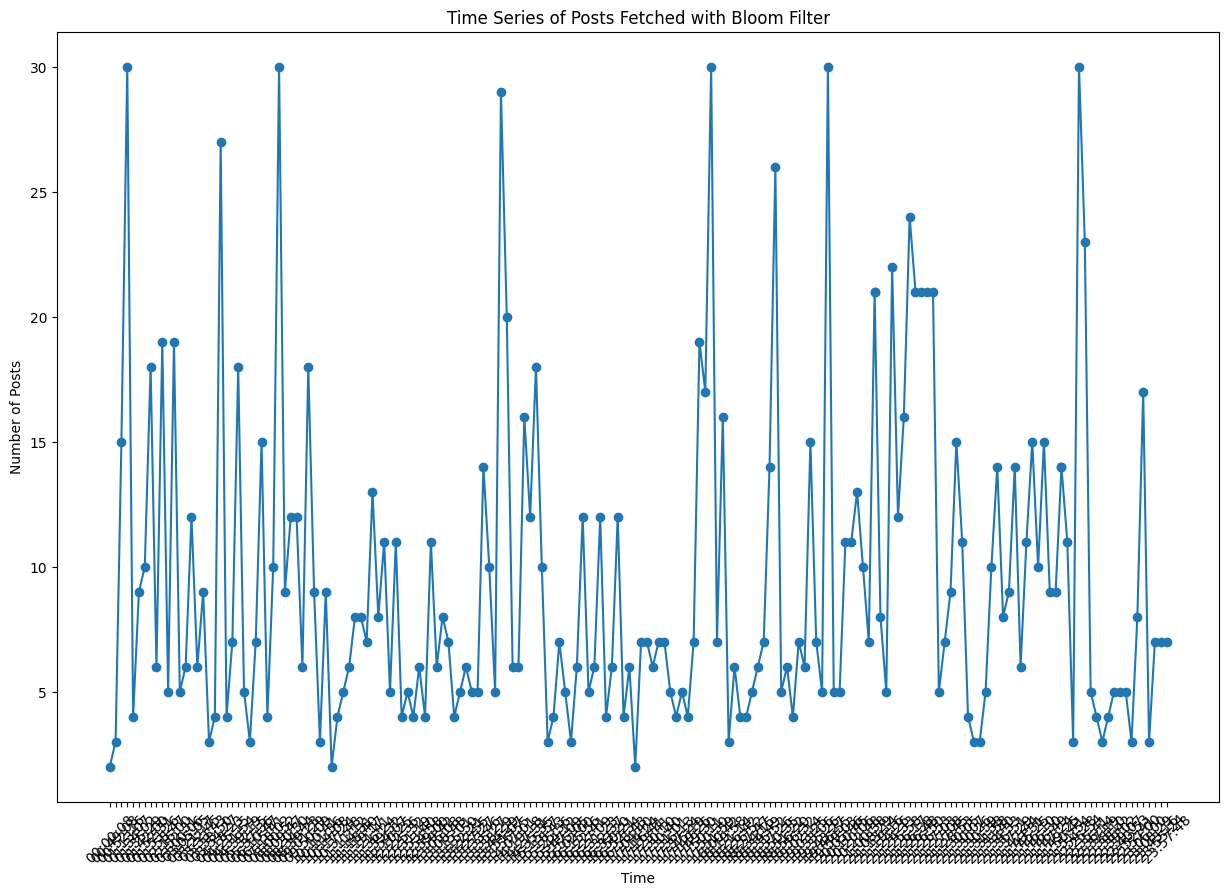

In [146]:
visualize_time_series(posts_data_with_bloom_filter, 'Time Series of Posts Fetched with Bloom Filter')

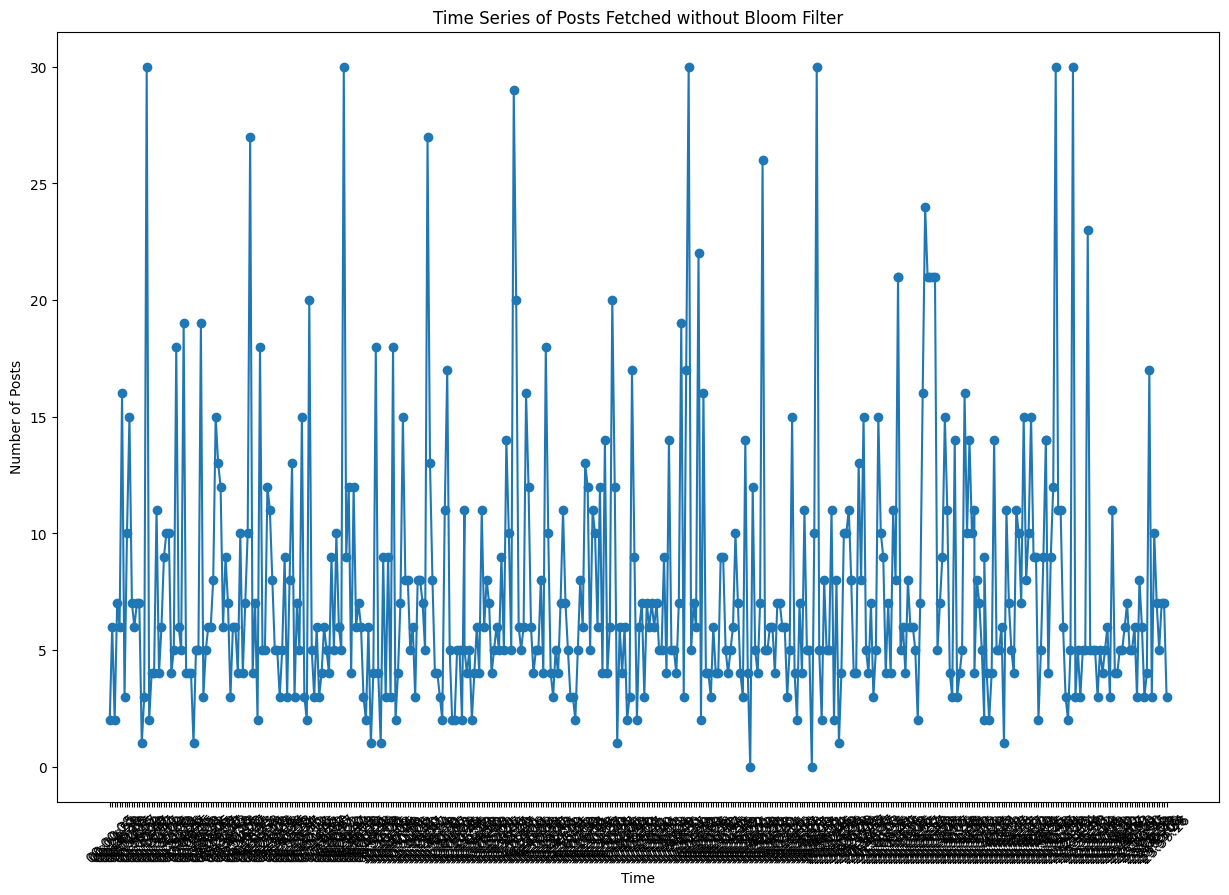

In [147]:
visualize_time_series(posts_data_without_bloom_filter, 'Time Series of Posts Fetched without Bloom Filter')

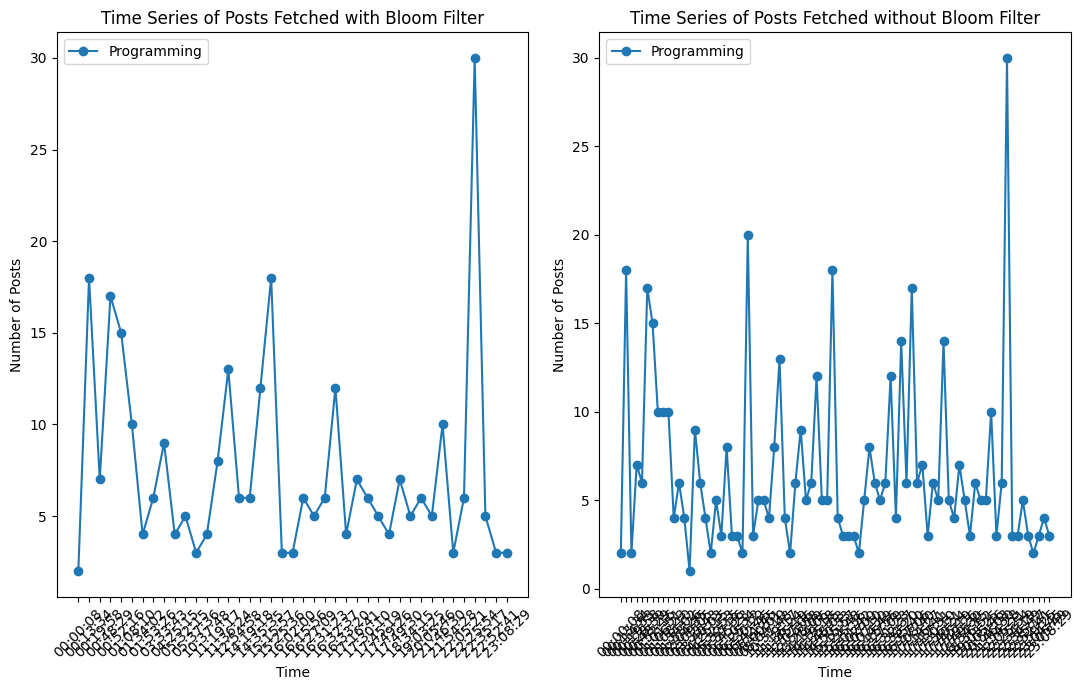

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(11, 7))

visualize_time_series_topicwise(posts_data_with_bloom_filter, 'Time Series of Posts Fetched with Bloom Filter', 'Programming', axs[0])
visualize_time_series_topicwise(posts_data_without_bloom_filter, 'Time Series of Posts Fetched without Bloom Filter', 'Programming', axs[1])

plt.tight_layout()
plt.show()

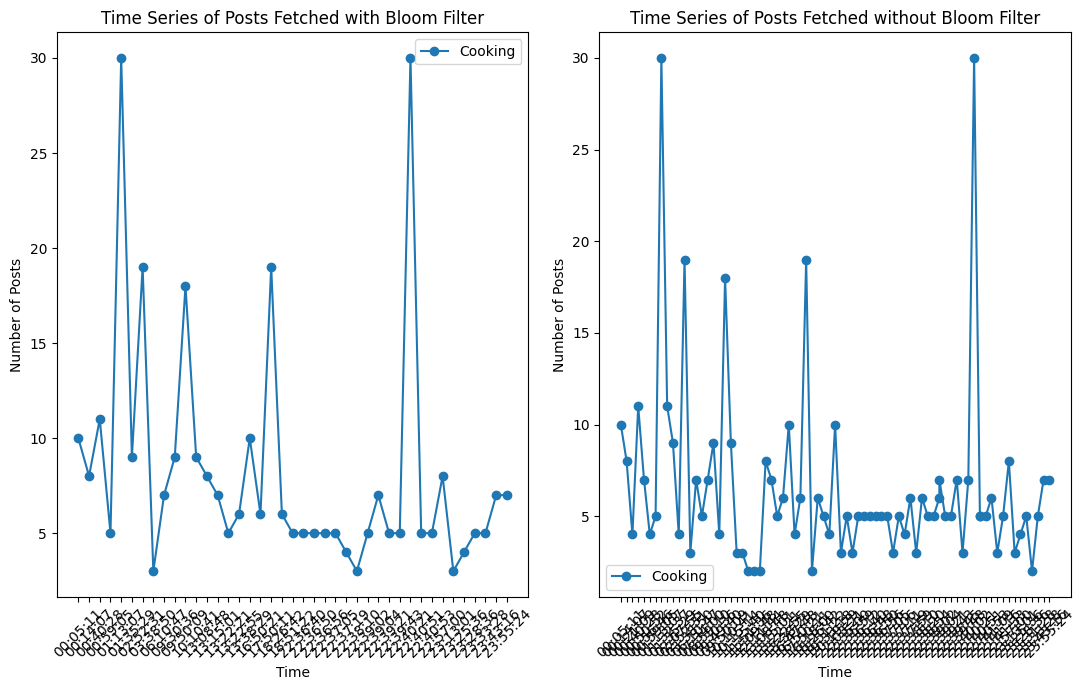

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(11, 7))

visualize_time_series_topicwise(posts_data_with_bloom_filter, 'Time Series of Posts Fetched with Bloom Filter', 'Cooking', axs[0])
visualize_time_series_topicwise(posts_data_without_bloom_filter, 'Time Series of Posts Fetched without Bloom Filter', 'Cooking', axs[1])

plt.tight_layout()
plt.show()

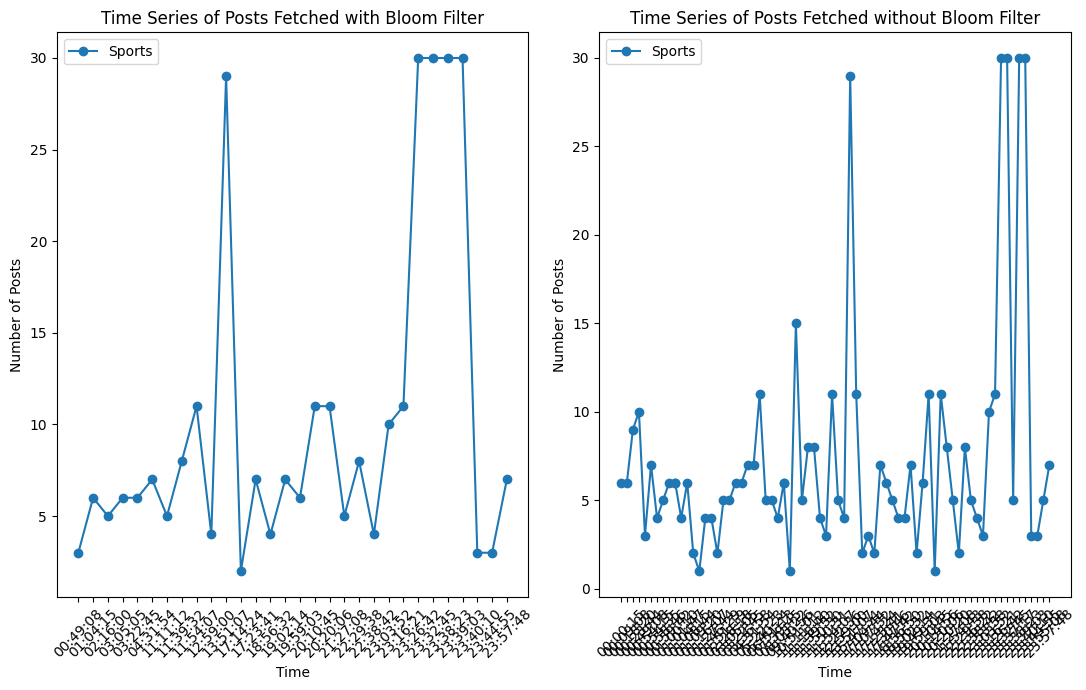

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(11, 7))

visualize_time_series_topicwise(posts_data_with_bloom_filter, 'Time Series of Posts Fetched with Bloom Filter', 'Sports', axs[0])
visualize_time_series_topicwise(posts_data_without_bloom_filter, 'Time Series of Posts Fetched without Bloom Filter', 'Sports', axs[1])

plt.tight_layout()
plt.show()

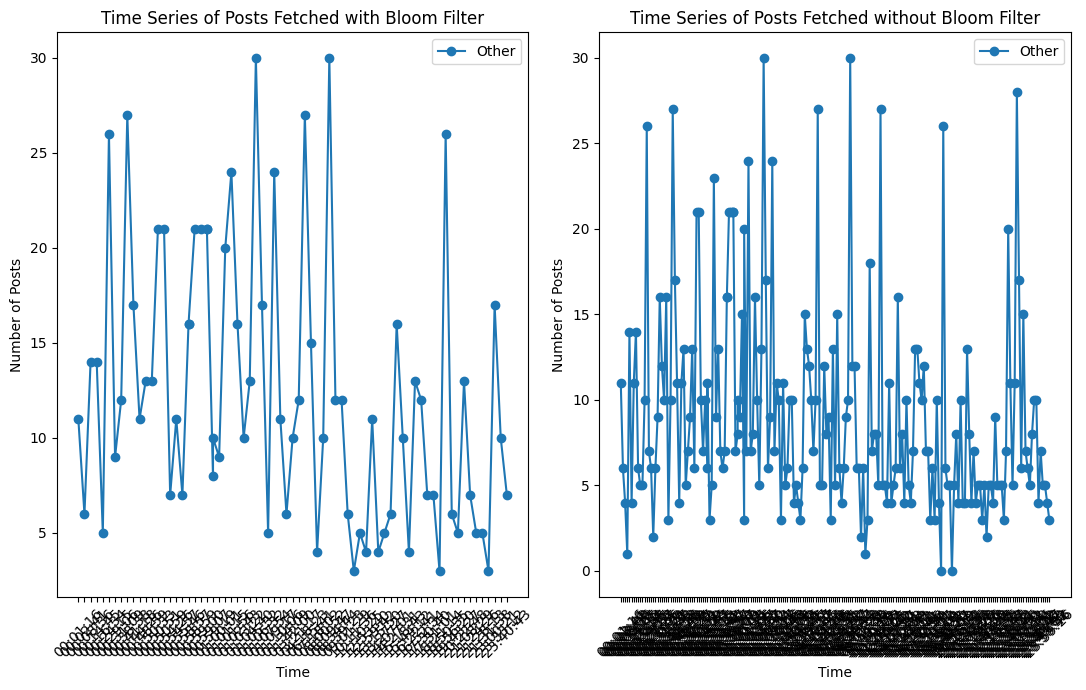

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(11, 7))

visualize_time_series_topicwise(posts_data_with_bloom_filter, 'Time Series of Posts Fetched with Bloom Filter', 'Other', axs[0])
visualize_time_series_topicwise(posts_data_without_bloom_filter, 'Time Series of Posts Fetched without Bloom Filter', 'Other', axs[1])

plt.tight_layout()
plt.show()

# WordCloud

**Using Bloom Filters**

In [41]:
words_of_programming = []
words_of_cooking = []
words_of_sports = []
words_of_other = []

for post in posts_data_with_bloom_filter:
    if post['Label'] == 'Programming':
        words_of_programming.extend(post['Tags'])
        words_of_programming.extend(post['Post Summary'].split())
    elif post['Label'] == 'Cooking':
        words_of_cooking.extend(post['Tags'])
        words_of_cooking.extend(post['Post Summary'].split())
    elif post['Label'] == 'Sports':
        words_of_sports.extend(post['Tags'])
        words_of_sports.extend(post['Post Summary'].split())
    elif post['Label'] == 'Other':
        words_of_other.extend(post['Tags'])
        words_of_other.extend(post['Post Summary'].split())

In [42]:
# word cloud for each category
wordcloud_programming = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(stopwords.words('english')), 
                min_font_size = 10).generate(' '.join(words_of_programming))

wordcloud_cooking = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(' '.join(words_of_cooking))

wordcloud_sports = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(' '.join(words_of_sports))

wordcloud_other = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(' '.join(words_of_other))

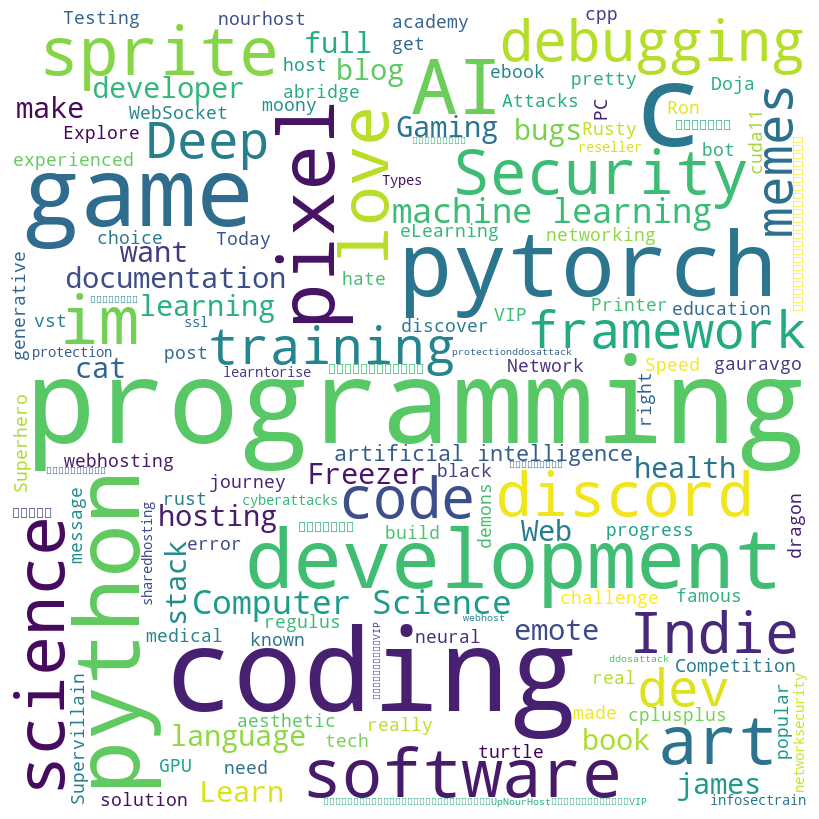

In [43]:
# programming word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_programming)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

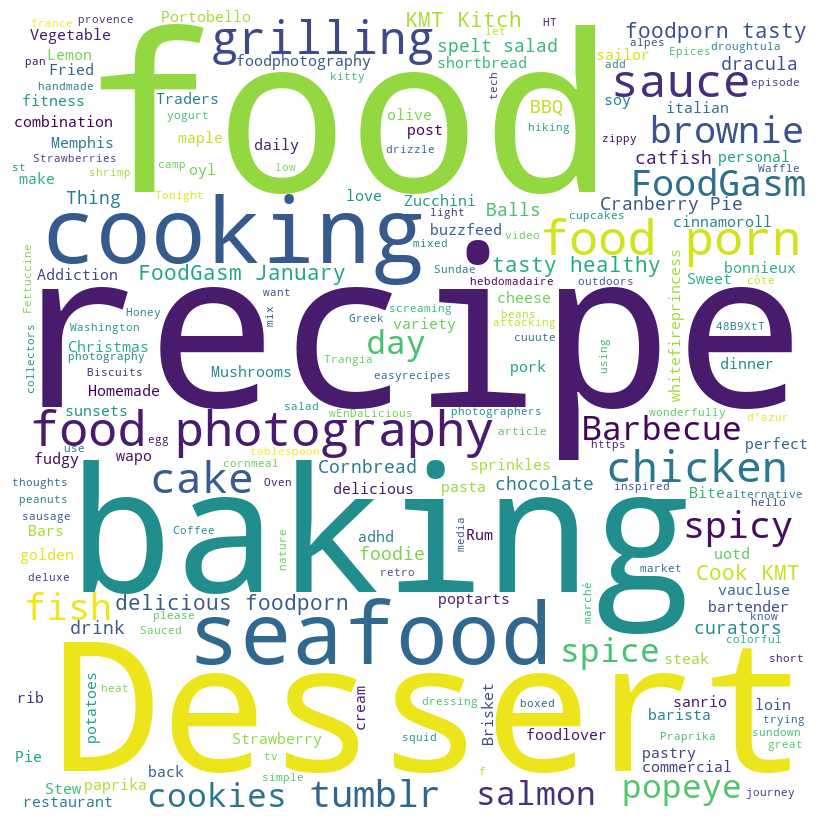

In [44]:
# cooking word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_cooking)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

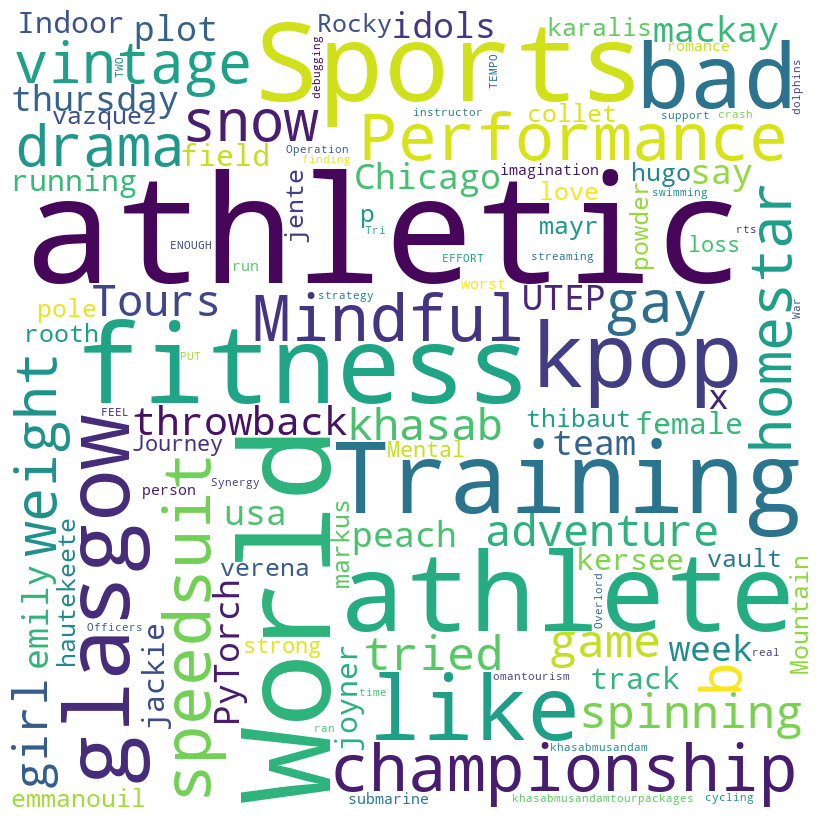

In [45]:
# sports word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_sports)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

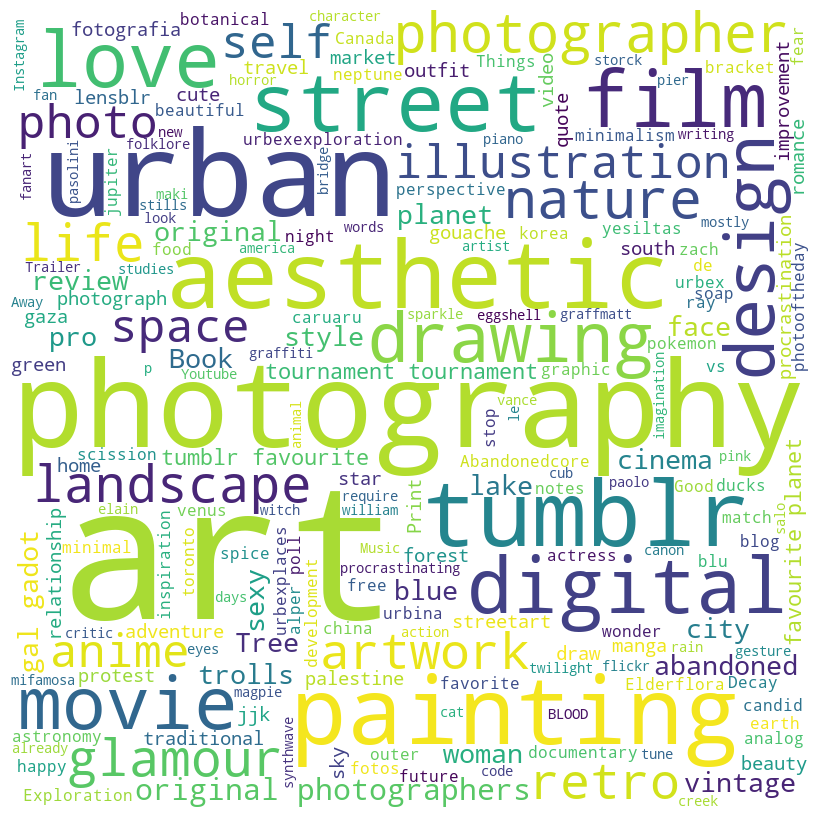

In [46]:
# other word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_other)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**Without Using Bloom Filters**

In [47]:
words_of_programming_without_bloom = []
words_of_cooking_without_bloom = []
words_of_sports_without_bloom = []
words_of_other_without_bloom = []

for post in posts_data_without_bloom_filter:
    if post['Label'] == 'Programming':
        words_of_programming_without_bloom.extend(post['Tags'])
        words_of_programming_without_bloom.extend(post['Post Summary'].split())
    elif post['Label'] == 'Cooking':
        words_of_cooking_without_bloom.extend(post['Tags'])
        words_of_cooking_without_bloom.extend(post['Post Summary'].split())
    elif post['Label'] == 'Sports':
        words_of_sports_without_bloom.extend(post['Tags'])
        words_of_sports_without_bloom.extend(post['Post Summary'].split())
    elif post['Label'] == 'Other':
        words_of_other_without_bloom.extend(post['Tags'])
        words_of_other_without_bloom.extend(post['Post Summary'].split())

In [48]:
# word cloud for each category

wordcloud_programming_without_bloom = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(' '.join(words_of_programming_without_bloom))

wordcloud_cooking_without_bloom = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(' '.join(words_of_cooking_without_bloom))

wordcloud_sports_without_bloom = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(' '.join(words_of_sports_without_bloom))

wordcloud_other_without_bloom = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(' '.join(words_of_other_without_bloom))

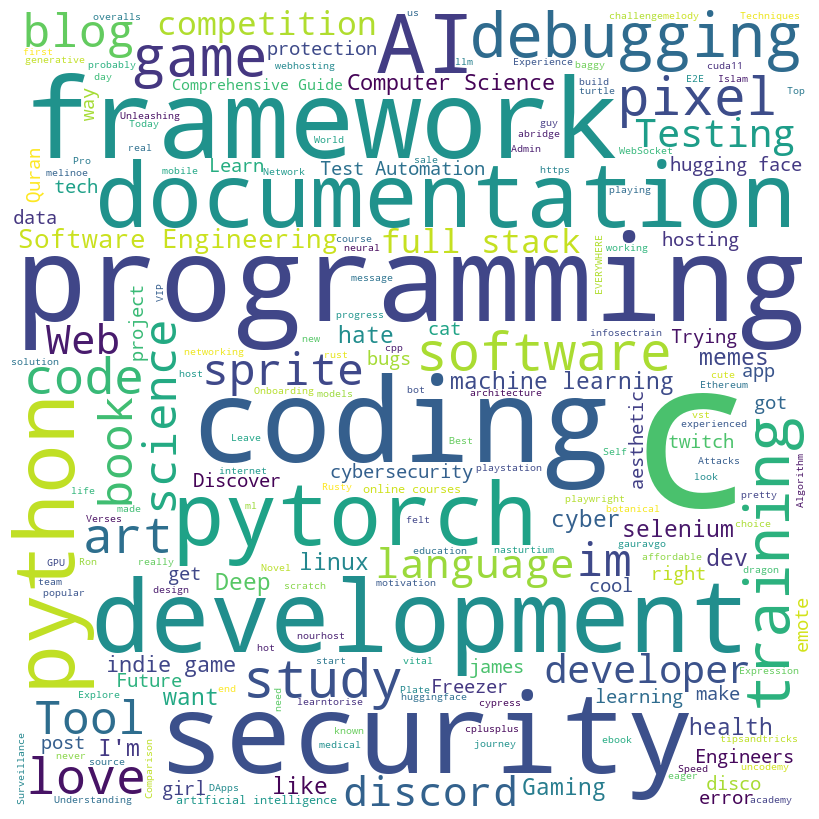

In [49]:
# programming word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_programming_without_bloom)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

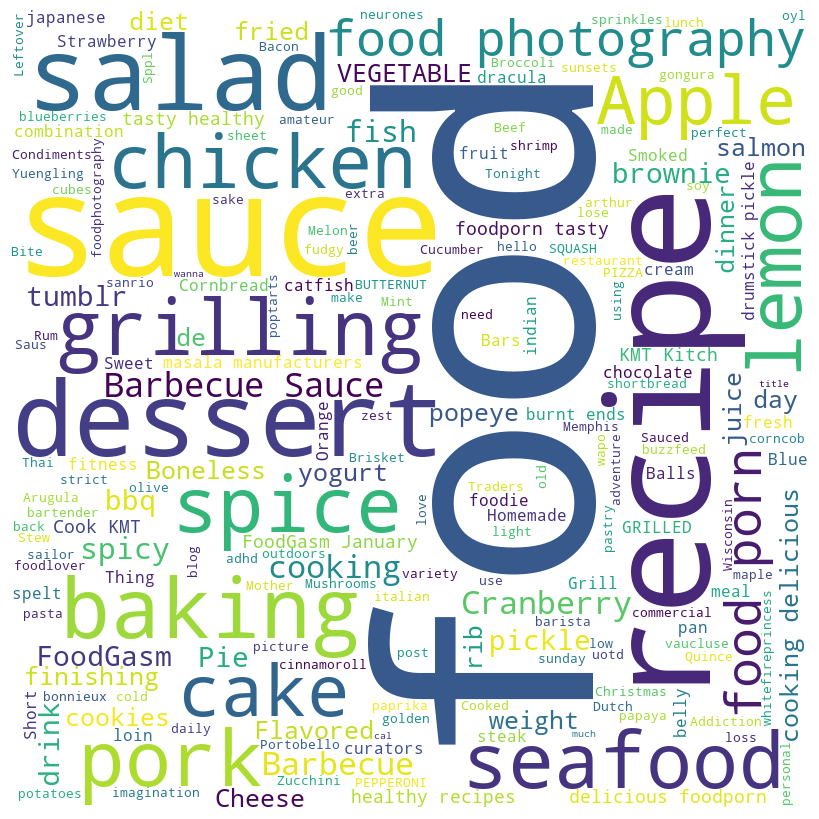

In [50]:
# cooking word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_cooking_without_bloom)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

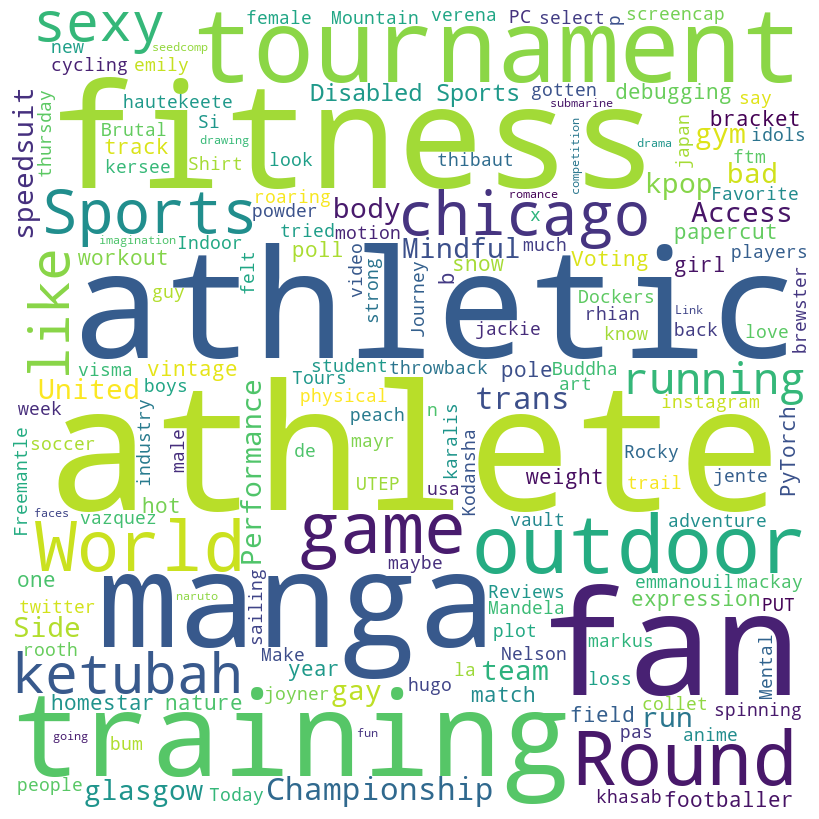

In [51]:
# sports word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_sports_without_bloom)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

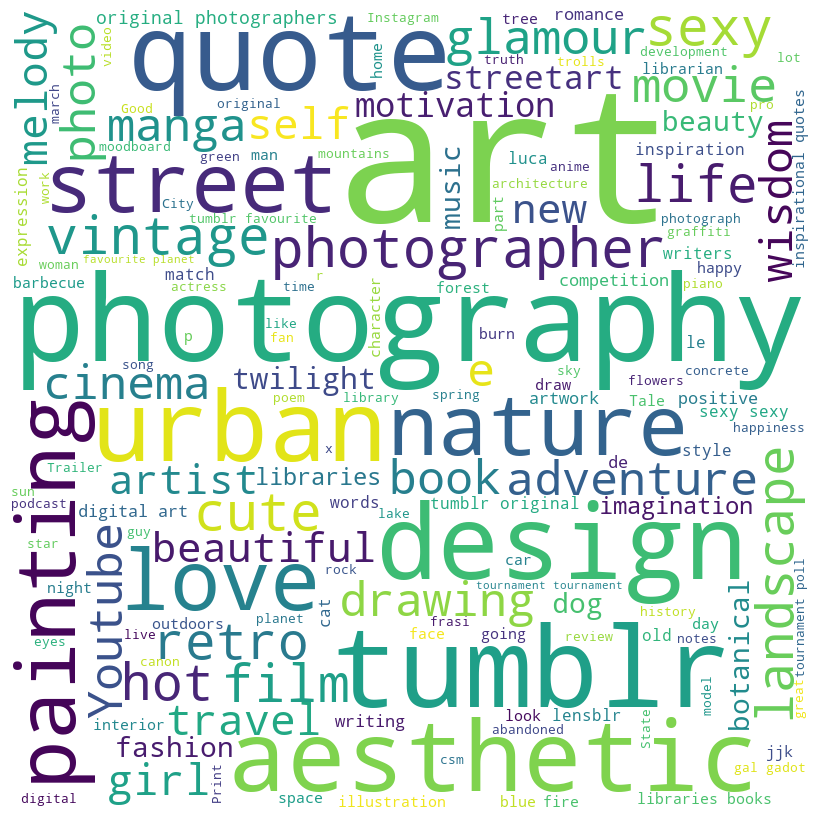

In [52]:
# other word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_other_without_bloom)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Heat Maps

In [61]:
def plot_heatmap(df):
    timestamps = [post['timestamp'] for post in df]
    tags = [tag for post in df for tag in post['Tags']]
    heatmap_data = pd.DataFrame(index=list(set(timestamps)), columns=list(set(tags)))

    for post in df:
        timestamp = post['timestamp']
        for tag in post['Tags']:
            if pd.notna(heatmap_data.at[timestamp, tag]):
                heatmap_data.at[timestamp, tag] += 1
            else:
                heatmap_data.at[timestamp, tag] = 1

    heatmap_data.fillna(0, inplace=True)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap="YlGnBu")
    plt.title("Heatmap of Tags over Time")
    plt.xlabel("Tags")
    plt.ylabel("Timestamps")
    plt.show()

**With Bloom Filters**

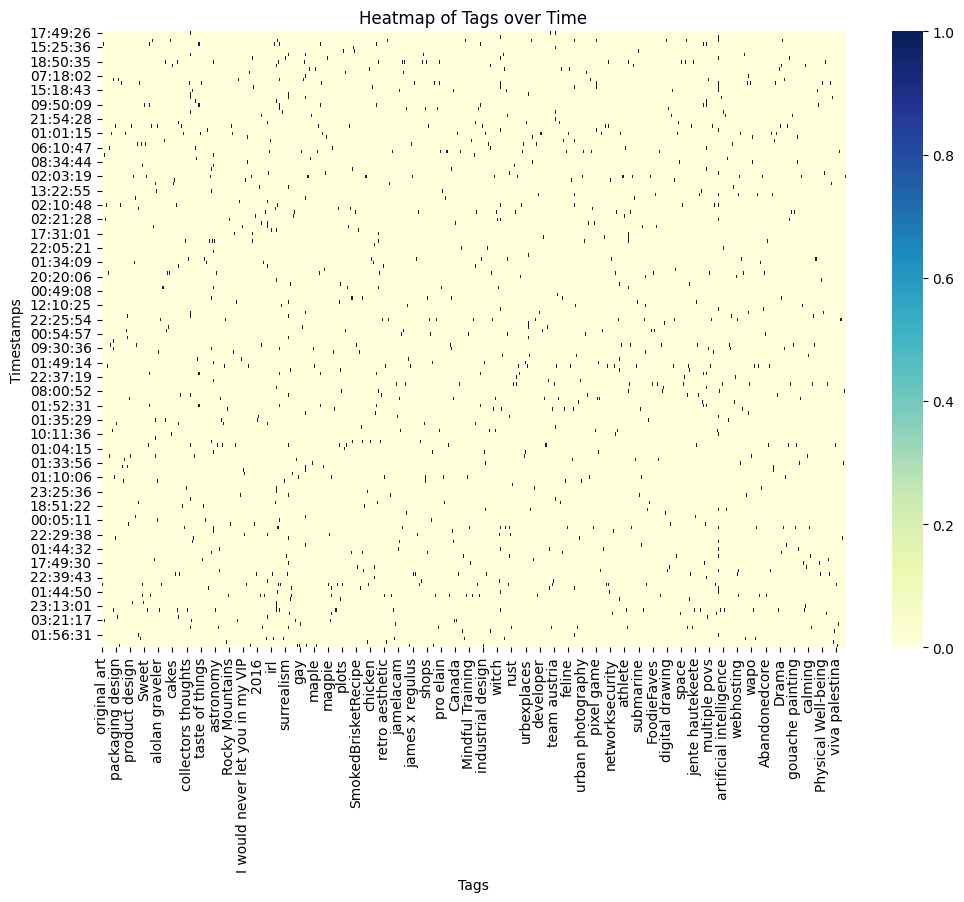

In [62]:
plot_heatmap(posts_data_with_bloom_filter)

**Without Bloom Filters**

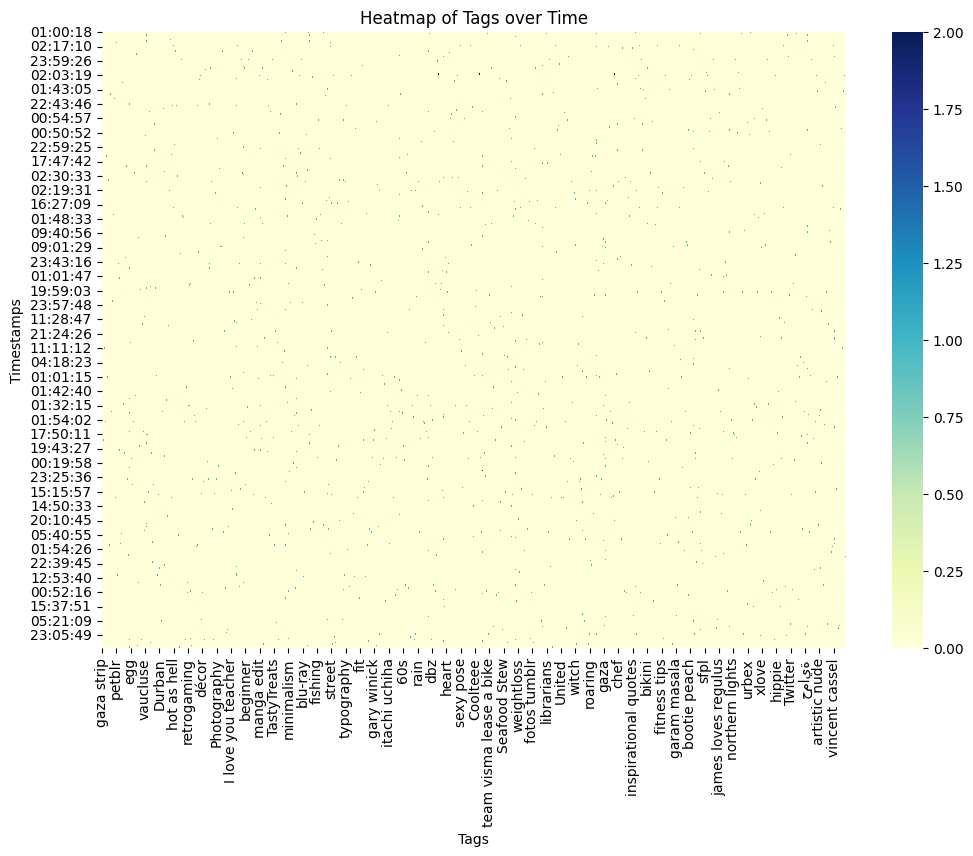

In [63]:
plot_heatmap(posts_data_without_bloom_filter)